# Stamp Rotation & Injection Tutorial Notebook

For the Rubin Science Platform at <a href="https://data.lsst.cloud">data.lsst.cloud</a><br>
Data Release: <a href="https://dp1.lsst.io/">Data Preview 1 (DP1)</a> <br>

**Learning Objective:** To learn how to appropriately rotate injected stamps into DP1 data. 

**LSST Data Products:** `visit_image`, `deep_coadd`

**Packages:** `lsst.daf.butler`, `lsst.rsp`, `lsst.source.injection`, `lsst.afw.display`

**Credit:** This notebook was created by Dhruv Sharma using code developed by Shenming Fu (SLAC National Accelerator Laboratory)

## 1. Introduction

Injecting stamps (in the form of `.fits` files) enables us to insert many different kinds of sources beyond the standard `Star` and `Sersic` models already provided in our catalog generation methods. However, stamps are always injected the same way in all images, irrespective of what orientation that image has.

This means that injecting into `deep_coadd` and `visit_image` data must be a considered process, as we know `deep_coadd`s cover a single patch and are provided to us aligned to the ra,dec coordinate system, whereas `visit_image`s may be rotated by a given boresight angle (counterclockwise from +y). Therefore, if we want our stamps to remain consistent in their orientation between both products, we must rotate stamps injected into a `visit_image` relative to the `deep_coadd`.

### 1.1. Import packages

Import all the packages we'll need in this tutorial, starting with `lsst.daf.butler` to query DP1 images. We'll use the `lsst.source.injection` module extensively to generate and inject our stamp catalogs, as well as some modules of `lsst.afw` for help performing the stamp rotations. Also import some of our files from `lib` to access their helpful methods.

In [1]:
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from lsst.source.injection import generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.source.injection import CoaddInjectConfig, CoaddInjectTask
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Table, vstack
from lib.visual import *
from lib.inject import *
from lib.stamp import *

Run the below cell to specify that we want matplotlib to draw plots directly within the Jupyter Notebook.

In [2]:
%matplotlib inline

### 1.2. Using the Butler to retrieve visit images

Create a new instance of the Butler configured to query DP1 data from the LSSTComCam.

In [3]:
BUTLER_CONFIG = "dp1"
COLLECTIONS = "LSSTComCam/DP1"
butler = Butler(BUTLER_CONFIG, collections=COLLECTIONS) 
afwDisplay.setDefaultBackend("matplotlib")
afw_display = afwDisplay.Display(frame=1)

<Figure size 640x480 with 0 Axes>

Use the Butler's `query_datasets` method to find `visit_image`s corresponding to the  band and ra,dec (right-ascension, declination) coordinates given in the "bind" of the formatted string, in this case:
>ra = 37.93, dec = 6.93 <br>
>band = 'r'

There can and often may be be multiple visit images covering the same ra,dec position, as seen by printing the length of `visit_data`.

In [4]:
ra=37.93
dec=6.93
band = 'r'
query = "band.name = :band AND \
    visit_detector_region.region OVERLAPS POINT(:ra, :dec)"
bind = {"band": band, "ra": ra, "dec": dec}
visit_data = butler.query_datasets("visit_image",
                                     where=query,
                                     order_by=["visit.timespan.begin"],
                                     bind=bind)

print(len(visit_data))

9


We hope to inject sources into both a `visit_image` and a `deep_coadd` image, so we should choose a visit that shares significant overlap with the coadd. For the sake of this tutorial, we'll retrieve the image of index 4 from the `visit_data` dataset containing all the visits that fulfilled the criteria laid out in our query.

In [5]:
visit = butler.get(visit_data[4])

Also get a few parameters of the visit image that we'll need to perform our catalog generation and injection. Namely, the `visit_wcs`, or World Coordinate System of the visit image, as well as the `visit_psf` or point-spread function and the photo calibrations `visit_photo_calib`.

In [6]:
visit_wcs = visit.getWcs()
visit_psf = visit.getPsf()
visit_photo_calib = visit.getPhotoCalib()

## 2. Injecting Rotated Stamps into Visit Images

With our `visit_image` information in hand, let's try to generate a catalog of SL-AGN stamps to inject into it. 

### 2.1. Getting SL-AGN Stamps From .fits Files

Now let's specify both our stamp magnitude and more importantly, which file we want to use. Stamps are stored as `.fits` files, which we have stored in the `fig` folder. Since this tutorial is concerned with rotations of stamps and stamp catalogs, not necessarily their magnitude or the stamps used themselves, we will use one fixed magnitude and stamp for all our injections today.

Our original stamp is stored in the file `system_1_0.fits`, though we won't use it for long. To rotate our stamp to match the orientations of other images, our stamp needs to have its own WCS information, which `.fits` files do not carry automatically. Thus, we'll use the `add_wcs` method to give our stamp a WCS and save it to a new file, `system_1_0_wcs.fits` in the same `fig` folder.

In [7]:
stamp_mag = 15
stamp_filename = "fig/system_1_0.fits"
add_wcs(stamp_filename)
wcs_stamp_filename = "%s_wcs.fits"%stamp_filename[:-5]

Here's where we must make a decision on what we want to establish as our "baseline" stamp. How should the source appear when aligned to the ra,dec coordinate system? In this notebook, we will consider the provided stamp to be our "baseline" and make rotations of that stamp to fit our `visit_image` captures. Since `deep_coadd` images are already aligned to the ra,dec grid, we can simply inject the stamp we have now into those. Let's continue with visit images for now.

### 2.2. Creating Rotated Stamp Files

To inject our stamp into the `visit_image`, we first have to rotate it to match the angle the image was taken. To start, let's load the `.fits` file corresponding to our "baseline" stamp.

In [8]:
stamp_img_orig = afwImage.ExposureF.readFits(wcs_stamp_filename)

We're almost ready to rotate our stamp and inject it into a coadd! Just one question remains: How much do we actually need to rotate our stamp by?

Since the coadd image will always be aligned to the ra,dec coordinate system, we can simply take advantage of the `getBoresightRotAngle()` method within each image's `visitInfo` attribute that gives its rotation counterclockwise from the _+dec_ axis in degrees. Try running the cell below to see the boresight angle of our `visit_image`.

In [9]:
visit.visitInfo.getBoresightRotAngle().asDegrees()

211.836229632274

Now use the `rotate_exposure` method to rotate the stamp by the boresight angle we just found. The method rotates clockwise, however, so we multiply by -1 to account for this.

In [10]:
stamp_img_rotated = rotate_exposure(stamp_img_orig, -1*visit.visitInfo.getBoresightRotAngle().asDegrees())

Let's view both our stamps side-by-side by running the cell below!

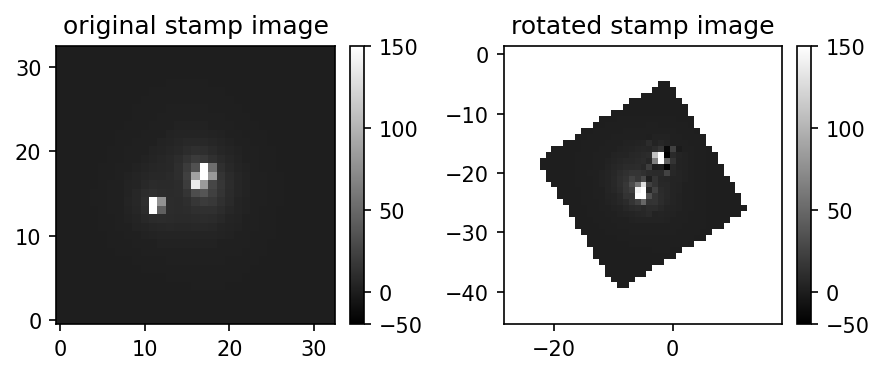

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', min=-20, max=150)
display0.mtv(stamp_img_orig.image)
plt.title('original stamp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', min=-20, max=150)
display1.mtv(stamp_img_rotated.image)
plt.title('rotated stamp image')

plt.tight_layout()
plt.show()

The below line checks the `.fits` file of our rotated stamp and sets any empty/undefined pixels to 0 (_NaN_ is short for "Not a Number").

In [12]:
stamp_img_rotated.image.array[np.where(np.isnan(stamp_img_rotated.image.array))] = 0.0

Now let's save our rotated image to a new `.fits` file in the `fig` folder. We'll save some information regarding the rotated stamp and then write it to `rotated_system_1_0_wcs.fits` for injection into our `visit_image`.

In [13]:
rot_stamp_mag = 15
rot_stamp_filename = wcs_stamp_filename[:4]+'rotated_'+wcs_stamp_filename[4:]
stamp_img_rotated.writeFits(rot_stamp_filename)

### 2.3. Creating & Injecting a Visit Catalog of Rotated Stamps

Use the `make_grid_coord` method to generate a catalog of our rotated stamps using the file pointed to by `rot_stamp_filename` in the shape of a grid covering the `visit_image`. Observe that our sources are aligned to the pixel grid of the `visit_image`, but are rotated relative to the ra,dec coordinate axes.

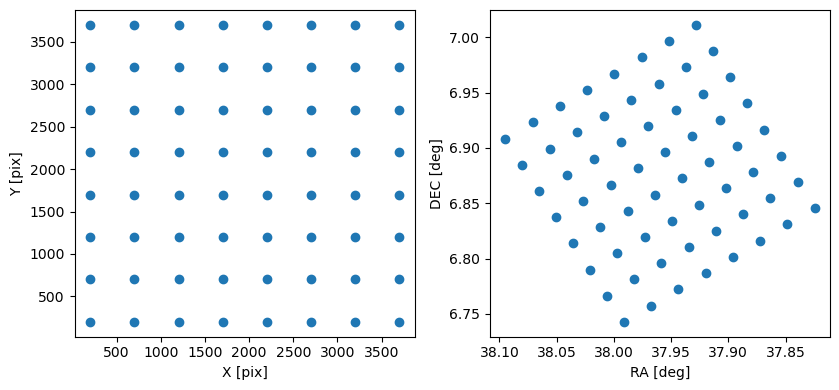

In [14]:
inj_catalog_visit = make_grid_coord(visit_wcs, rot_stamp_mag, rot_stamp_filename)

We'll then have the `visit_inject_stamp` method inject our `inj_catalog_visit` stamp catalog into the visit and save it to a new image, `inj_visit`.

In [15]:
inj_visit = visit_inject_stamp(visit, inj_catalog_visit)

Now draw the `inj_visit` injected visit image. See that the stamps have been injected in a grid pattern covering the whole capture.

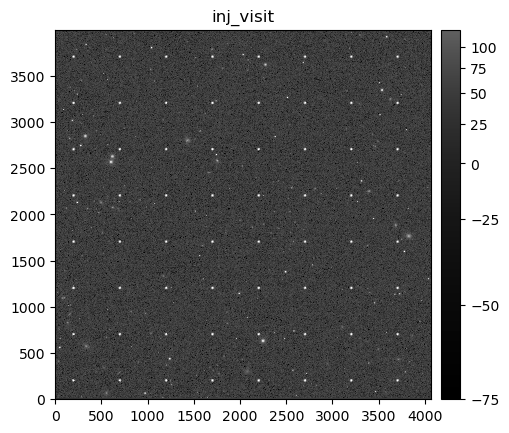

In [16]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(inj_visit.image)
plt.title("inj_visit")
plt.show()

The stamps are quite small and seem to almost be point sources with a field of view this large. Let's zoom in on a single stamp to see what it actually looks like in the image up close. See that its shape resembles that of our rotated stamp. Success!

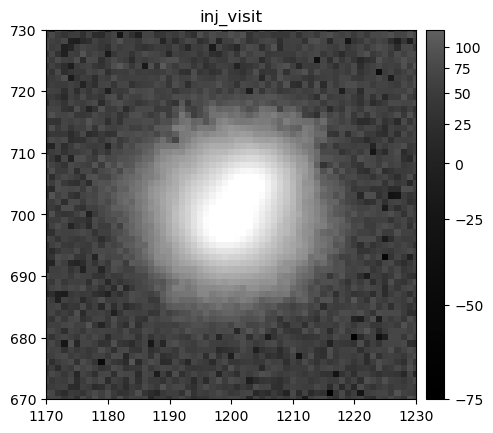

In [17]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(inj_visit.image)
plt.title("inj_visit")
plt.xlim(1170,1230)
plt.ylim(670,730)
plt.show()

You can also view both the original and injected `visit_image` using `plot_save_two_images`:

0

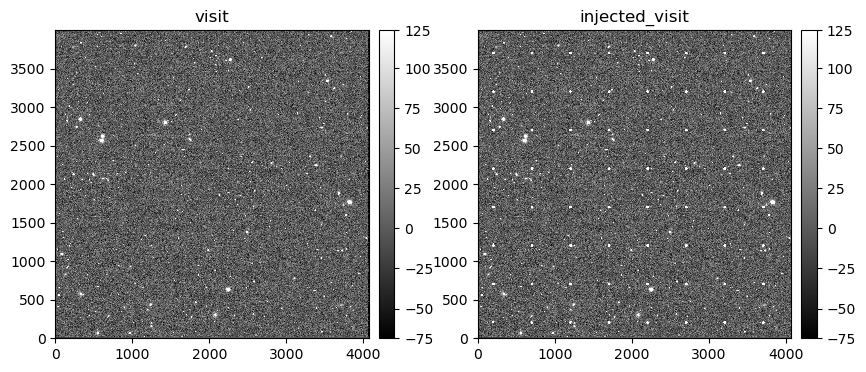

In [18]:
plot_save_two_images(visit, inj_visit, "visit", "injected_visit")

## 3. Injecting Stamp Catalogs into Coadd Images

Now let's prepare to inject the same source catalog into our coadd image. As `deep_coadd` images are already aligned with the ra,dec coordinate system, we can simply use our standard WCS-inclusive stamp. 

### 3.1. Querying for Deep Coadd Images Using Butler

First, let's query for the `deep_coadd` image using `Butler`, for which we search for the patch overlapping our chosen ra,dec coordinate.

In [19]:
query = "band.name = :band AND \
    patch.region OVERLAPS POINT(:ra, :dec)"
bind = {"band": band, "ra": ra, "dec": dec}
coadd_data = butler.query_datasets("deep_coadd",
                                     where=query,
                                     bind=bind)
print(len(coadd_data))

1


There's only one `deep_coadd` image satisfying these criteria, so we'll simply query for the first (0 indexed) image from the dataset.

In [20]:
coadd = butler.get(coadd_data[0])

We can also view the `deep_coadd` image we get below.

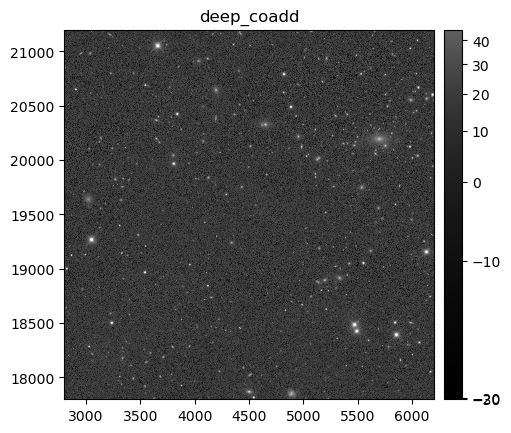

In [21]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.title("deep_coadd")
plt.show()

### 3.2. Creating & Injecting Catalogs of Stamps in Coadd Images

We'll also try to use a different method from last time to generate our injection catalog. Since catalogs are stored as `Table`s, we can create a new one and append it using `vstack` with new entries matching each line of the `visit_image` catalog, just replacing the `stamp` name with `wcs_stamp_filename` such that we use the non-rotated, original stamp with a WCS applied.

In [22]:
inj_catalog_coadd = Table()

for i in range(len(inj_catalog_visit)):
    inj_catalog_coadd = vstack([inj_catalog_coadd, Table(
        {
            'ra': [inj_catalog_visit[i][0]],
            'dec': [inj_catalog_visit[i][1]],
            'source_type': [inj_catalog_visit[i][2]],
            'mag': [inj_catalog_visit[i][3]],
            'stamp': [wcs_stamp_filename],
        }
    )])

Inject the sources from the table into our `deep_coadd` image similar to the `visit_image`, just this time using the `template_inject_stamp` method.

In [23]:
inj_coadd = template_inject_stamp(coadd, inj_catalog_coadd)

View the injected `deep_coadd` image below. Observe that the sources are all rotated relative to the axes of the image, just as we saw before. While `deep_coadd` images are aligned with the ra,dec coordinate axes, `visit_images` are hardly ever the same orientation and thus we see the apparent rotation of where our sources are.

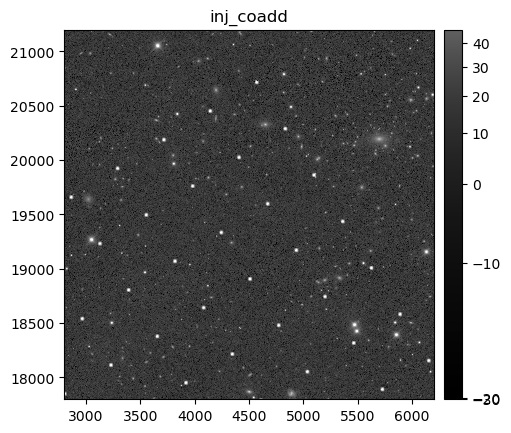

In [24]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(inj_coadd.image)
plt.title("inj_coadd")
plt.show()

Let's once again examine how the individual stamps themselves look. In this case since we applied no rotations we expect them to appear identical in shape to the original `.fits` stamp information. Verify that is the case below.

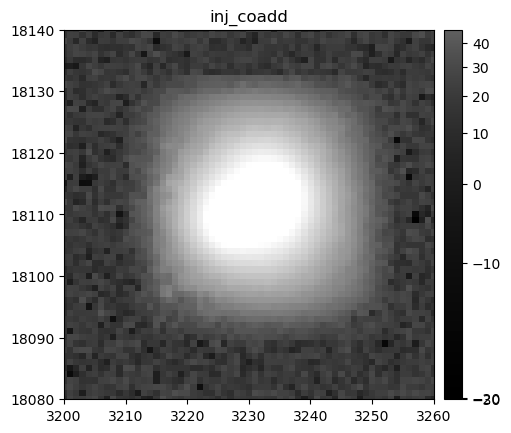

In [25]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(inj_coadd.image)
plt.xlim(3200,3260)
plt.ylim(18080,18140)
plt.title("inj_coadd")
plt.show()

## 4. Viewing Frames of Visit and Coadd Images

As an additinal task, we can try representing the `visit_image` and `deep_coadd` images as a diagram to show us the two captured regions overlaid on one another. To do that, let's first define a function to roughly convert pixels to sky coordinate degrees.

In [26]:
def pixel_to_degrees(n):
    return 0.2 * n / 3600

We'll also need to import a few new packages, mainly from `matplotlib` and `astropy` to help us draw the regions.

In [27]:
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import numpy as np
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import Quadrangle
from astropy import units as u

Now run the below code to see visually what the images look like overlaid on one another. 

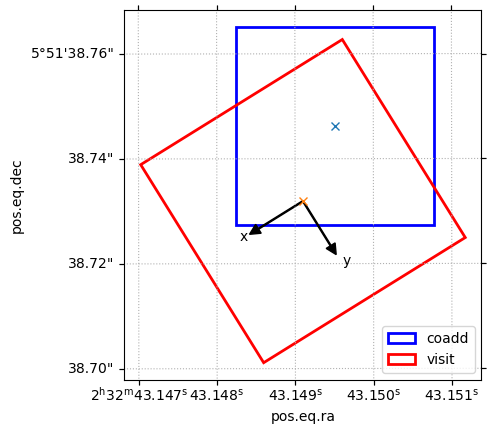

In [28]:
# Create figure and axes
fig = plt.figure()
ax = plt.subplot(projection=WCS(coadd.getWcs().getFitsMetadata()))

# Draw Coadd Rectangle
coadd_cen = coadd.wcs.pixelToSky(coadd.getBBox().getCenter())
coadd_ra = coadd_cen.getRa().asDegrees()
coadd_dec = coadd_cen.getDec().asDegrees()
coadd_width = pixel_to_degrees(coadd.width)
coadd_height = pixel_to_degrees(coadd.height)
coadd_rect = patches.Rectangle(
    (coadd_ra - coadd_width / 2, coadd_dec - coadd_height / 2),  # lower-left corner
    coadd_width,
    coadd_height,
    angle=0,
    rotation_point = 'center',
    linewidth=2,
    edgecolor='blue',
    facecolor='none'
)

# Draw Visit Rectangle
visit_cen = visit.wcs.pixelToSky(visit.getBBox().getCenter())
visit_ra = visit_cen.getRa().asDegrees()
visit_dec = visit_cen.getDec().asDegrees()
visit_width = pixel_to_degrees(visit.width)
visit_height = pixel_to_degrees(visit.height)
visit_angle = -visit.visitInfo.getBoresightRotAngle().asDegrees()
visit_rect = patches.Rectangle(
    (visit_ra - visit_width / 2, visit_dec - visit_height / 2),  # lower-left corner
    visit_width,
    visit_height,
    angle=visit_angle,
    rotation_point = 'center',
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)

# Invert x-axis (RA)
ax.invert_xaxis()

# Add rectangles to plot
ax.add_patch(coadd_rect)
ax.add_patch(visit_rect)

# Plot Centers of Rectangles with x's
ax.plot([coadd_ra],[coadd_dec], 'x')
ax.plot([visit_ra],[visit_dec], 'x')

# Show xy axes of visit
angle = visit.visitInfo.boresightRotAngle.asDegrees()
theta_rad = np.deg2rad(-angle)
dx = 0.05 * np.cos(theta_rad)
dy = 0.05 * np.sin(theta_rad)
plt.arrow(visit_ra, visit_dec, -dx, -dy,
          head_width=0.01, head_length=0.01, fc='black', ec='black')# Set axis limits and aspect
plt.arrow(visit_ra, visit_dec, -dy, dx,
          head_width=0.01, head_length=0.01, fc='black', ec='black')# Set axis limits and aspect
plt.annotate('x', xy=(visit_ra - dx/0.7, visit_dec - dy/0.7))
plt.annotate('y', xy=(visit_ra-dy/0.7,visit_dec+dx/0.7))

# Graph/Legend Properties
ax.set_aspect('equal')
plt.grid(ls=':')
plt.legend(["coadd", "visit"], loc="lower right")

And we're done! Congratulations on completing the tutorial! You should now have a better understanding of how stamp catalog generation and injection works, as well as how to rotate them to ensure their orientations are consistent between captures of the Rubin camera.